<a id="alos_land_change_top"></a>
# ALOS Land Change

<hr>

# Notebook Summary

This notebook tries to detect land change with ALOS-2.

<hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#alos_land_change_import_connect)
* [Choose Platform and Product](#alos_land_change_plat_prod)
* [Get the Extents of the Cube](#alos_land_change_extents)
* [Define the Analysis Parameters](#alos_land_change_parameters)
* [Load and Clean Data from the Data Cube](#alos_land_change_load)
* [View RGBs for the Baseline and Analysis Periods](#alos_land_change_rgbs)
* [Plot HH or HV Band for the Baseline and Analysis Periods](#alos_land_change_hh_hv)
* [Plot a Custom RGB That Uses Bands from the Baseline and Analysis Periods](#alos_land_change_custom_rgb)
* [Plot a Change Product to Compare Two Time Periods (Epochs)](#alos_land_change_change_product)

## <span id="alos_land_change_import_connect">Import Dependencies and Connect to the Data Cube [&#9652;](#alos_land_change_top)</span>

In [1]:
import sys
import os
sys.path.append(os.environ.get('NOTEBOOK_ROOT'))

import datacube
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

dc = datacube.Datacube()

## <span id="alos_land_change_plat_prod">Choose Platform and Product [&#9652;](#alos_land_change_top)</span>

In [2]:
# Select one of the ALOS data cubes from around the world
# Colombia, Vietnam, Samoa Islands

## ALOS Data Summary
# There are 7 time slices (epochs) for the ALOS mosaic data. 
# The dates of the mosaics are centered on June 15 of each year (time stamp)
# Bands: RGB (HH-HV-HH/HV), HH, HV, date, incidence angle, mask)
# Years: 2007, 2008, 2009, 2010, 2015, 2016, 2017

platform = "ALOS/ALOS-2"
product = "alos_palsar_mosaic"

## <a id="alos_land_change_extents"></a> Get the Extents of the Cube [&#9652;](#alos_land_change_top)

In [3]:
from utils.data_cube_utilities.dc_time import dt_to_str

metadata = dc.load(platform=platform, product=product, measurements=[])

full_lat = metadata.latitude.values[[-1,0]]
full_lon = metadata.longitude.values[[0,-1]]
min_max_dates = list(map(dt_to_str, map(pd.to_datetime, metadata.time.values[[0,-1]])))

# Print the extents of the combined data.
print("Latitude Extents:", full_lat)
print("Longitude Extents:", full_lon)
print("Time Extents:", min_max_dates)

Latitude Extents: [-34.99988889  40.00011111]
Longitude Extents: [-20.00011111  54.99988889]
Time Extents: ['2007-07-02', '2017-07-02']


## <a id="alos_land_change_parameters"></a> Define the Analysis Parameters [&#9652;](#alos_land_change_top)

In [4]:
from datetime import datetime

## Somoa ##

# Apia City
# lat = (-13.7897, -13.8864)
# lon  = (-171.8531, -171.7171)
# time_extents = ("2014-01-01", "2014-12-31")

# East Area
# lat = (-13.94, -13.84)
# lon = (-171.96, -171.8)
# time_extents = ("2014-01-01", "2014-12-31")

# Central Area
# lat = (-14.057, -13.884)
# lon = (-171.774, -171.573)
# time_extents = ("2014-01-01", "2014-12-31")

# Small focused area in Central Region
# lat = (-13.9443, -13.884)
# lon = (-171.6431, -171.573)
# time_extents = ("2014-01-01", "2014-12-31")

## Kenya ##

# Mombasa
lat = (-4.1095, -3.9951)
lon = (39.5178, 39.7341)
time_extents = ("2007-01-01", "2017-12-31")

**Visualize the selected area**

In [5]:
from utils.data_cube_utilities.dc_display_map import display_map

display_map(lat, lon)  

## <a id="alos_land_change_load"></a> Load and Clean Data from the Data Cube [&#9652;](#alos_land_change_top)

In [6]:
dataset = dc.load(product = product, platform = platform, 
                  latitude = lat, longitude = lon, 
                  time=time_extents)

**View an acquisition in dataset**

In [7]:
# Select a baseline and analysis time slice for comparison
# Make the adjustments to the years according to the following scheme
# Time Slice: 0=2007, 1=2008, 2=2009, 3=2010, 4=2015, 5=2016, 6=2017)

baseline_slice = dataset.isel(time = 0)
analysis_slice = dataset.isel(time = -1)

## <a id="alos_land_change_rgbs"></a> View RGBs for the Baseline and Analysis Periods [&#9652;](#alos_land_change_top)

In [8]:
%matplotlib inline
from utils.data_cube_utilities.dc_rgb import rgb

(<Figure size 576x1087.26 with 1 Axes>,
 <AxesSubplot:xlabel='longitude', ylabel='latitude'>)

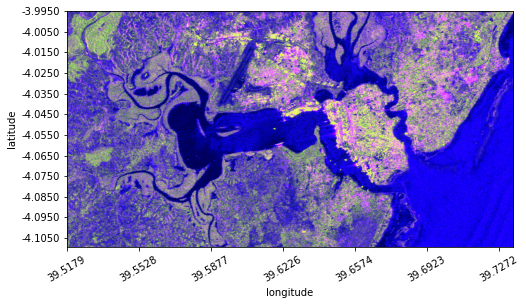

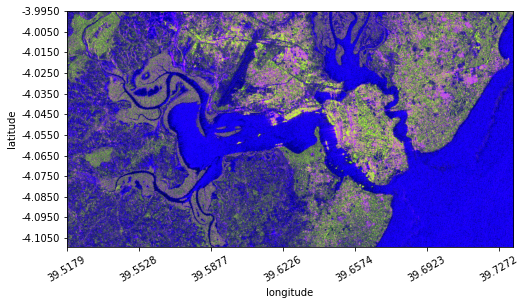

In [9]:
# Baseline RGB

rgb_dataset2 = xr.Dataset()
min_ = np.min([
    np.percentile(baseline_slice.hh,5),
    np.percentile(baseline_slice.hv,5),
])
max_ = np.max([
    np.percentile(baseline_slice.hh,95),
    np.percentile(baseline_slice.hv,95),
])
rgb_dataset2['base.hh'] = baseline_slice.hh.clip(min_,max_)/40
rgb_dataset2['base.hv'] = baseline_slice.hv.clip(min_,max_)/20
rgb_dataset2['base.ratio'] = (baseline_slice.hh.clip(min_,max_)/baseline_slice.hv.clip(min_,max_))*75
rgb(rgb_dataset2, bands=['base.hh','base.hv','base.ratio'], width=8)

# Analysis RGB

rgb_dataset2 = xr.Dataset()
min_ = np.min([
    np.percentile(analysis_slice.hh,5),
    np.percentile(analysis_slice.hv,5),
])
max_ = np.max([
    np.percentile(analysis_slice.hh,95),
    np.percentile(analysis_slice.hv,95),
])
rgb_dataset2['base.hh'] = analysis_slice.hh.clip(min_,max_)/40
rgb_dataset2['base.hv'] = analysis_slice.hv.clip(min_,max_)/20
rgb_dataset2['base.ratio'] = (analysis_slice.hh.clip(min_,max_)/analysis_slice.hv.clip(min_,max_))*75
rgb(rgb_dataset2, bands=['base.hh','base.hv','base.ratio'], width=8)

## <a id="alos_land_change_hh_hv"></a> Plot HH or HV Band for the Baseline and Analysis Periods [&#9652;](#alos_land_change_top)

NOTE: The HV band is best for deforestation detection

Typical radar analyses convert the backscatter values at the pixel level to dB scale.<br>
The ALOS coversion (from JAXA) is: Backscatter dB = 20 * log10( backscatter intensity) - 83.0

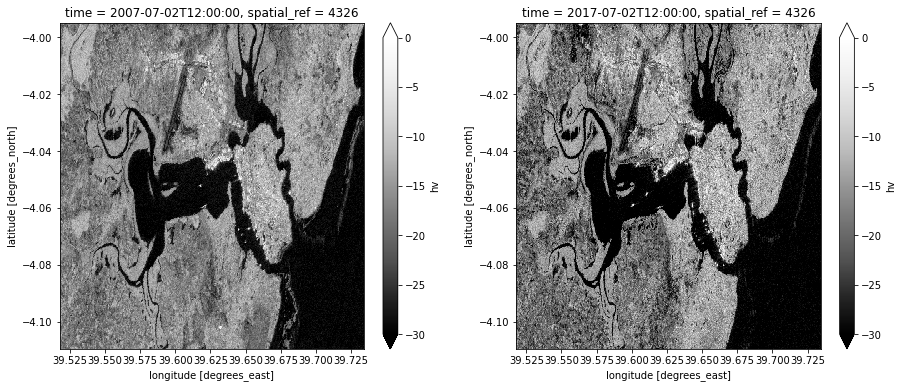

In [10]:
# Plot the BASELINE and ANALYSIS slice side-by-side
# Change the band (HH or HV) in the code below

plt.figure(figsize = (15,6))

plt.subplot(1,2,1)
(20*np.log10(baseline_slice.hv)-83).plot(vmax=0, vmin=-30, cmap = "Greys_r")
plt.subplot(1,2,2)
(20*np.log10(analysis_slice.hv)-83).plot(vmax=0, vmin=-30, cmap = "Greys_r")

## <a id="alos_land_change_custom_rgb"></a> Plot a Custom RGB That Uses Bands from the Baseline and Analysis Periods [&#9652;](#alos_land_change_top)

The RGB image below assigns RED to the baseline year HV band and GREEN+BLUE to the analysis year HV band<br>
Vegetation loss appears in RED and regrowth in CYAN. Areas of no change appear in different shades of GRAY.<br>
Users can change the RGB color assignments and bands (HH, HV) in the code below

(<Figure size 576x1087.26 with 1 Axes>,
 <AxesSubplot:xlabel='longitude', ylabel='latitude'>)

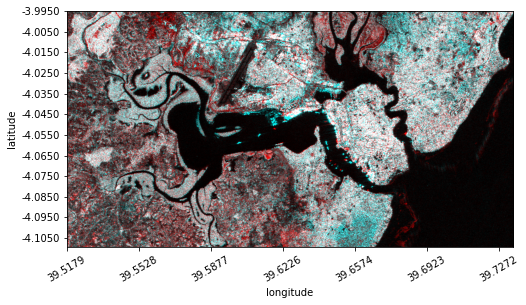

In [11]:
# Clipping the bands uniformly to brighten the image
rgb_dataset2 = xr.Dataset()
min_ = np.min([
    np.percentile(baseline_slice.hv,5),
    np.percentile(analysis_slice.hv,5),
])
max_ = np.max([
    np.percentile(baseline_slice.hv,95),
    np.percentile(analysis_slice.hv,95),
])
rgb_dataset2['baseline_slice.hv'] = baseline_slice.hv.clip(min_,max_)
rgb_dataset2['analysis_slice.hv'] = analysis_slice.hv.clip(min_,max_)

# Plot the RGB with clipped HV band values
rgb(rgb_dataset2, bands=['baseline_slice.hv','analysis_slice.hv','analysis_slice.hv'], width=8)

**Select one of the plots below and adjust the threshold limits (top and bottom)**

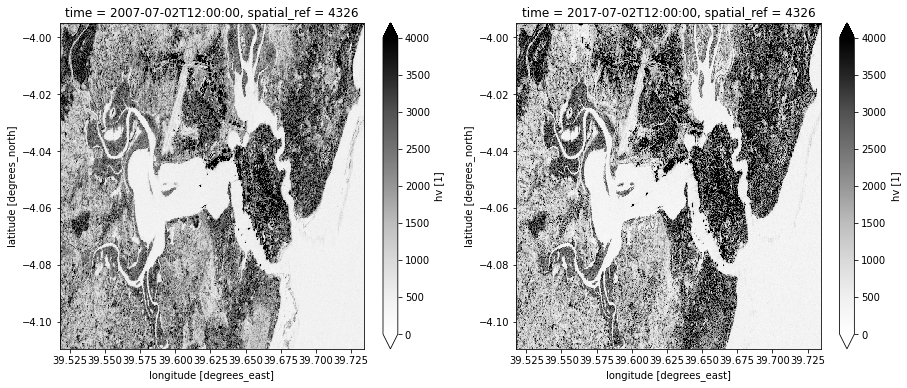

In [12]:
plt.figure(figsize = (15,6))
plt.subplot(1,2,1)
baseline_slice.hv.plot (vmax=0, vmin=4000, cmap="Greys")
plt.subplot(1,2,2)
analysis_slice.hv.plot (vmax=0, vmin=4000, cmap="Greys")

## <a id="alos_land_change_change_product"></a> Plot a Change Product to Compare Two Time Periods (Epochs) [&#9652;](#alos_land_change_top)

In [13]:
from matplotlib.ticker import FuncFormatter

def intersection_threshold_plot(first, second, th, mask = None, color_none=np.array([0,0,0]), 
                                color_first=np.array([0,255,0]), color_second=np.array([255,0,0]), 
                                color_both=np.array([255,255,255]), color_mask=np.array([127,127,127]), 
                                width = 10, *args, **kwargs):
    """
    Given two dataarrays, create a threshold plot showing where zero, one, or both are within a threshold.
    
    Parameters
    ----------
    first, second: xarray.DataArray
        The DataArrays to compare.
    th: tuple
        A 2-tuple of the minimum (inclusive) and maximum (exclusive) threshold values, respectively.
    mask: numpy.ndarray
        A NumPy array of the same shape as the dataarrays. The pixels for which it is `True` are colored `color_mask`.
    color_none: list-like
        A list-like of 3 elements - red, green, and blue values in range [0,255], used to color regions where neither
        first nor second have values within the threshold. Default color is black.
    color_first: list-like
        A list-like of 3 elements - red, green, and blue values in range [0,255], used to color regions where only the first 
        has values within the threshold. Default color is green.
    color_second: list-like
        A list-like of 3 elements - red, green, and blue values in range [0,255], used to color regions where only the second
        has values within the threshold. Default color is red.
    color_both: list-like
        A list-like of 3 elements - red, green, and blue values in range [0,255], used to color regions where both the
        first and second have values within the threshold. Default color is white.
    color_mask: list-like
        A list-like of 3 elements - red, green, and blue values in range [0,255], used to color regions where `mask == True`.
        Overrides any other color a region may have. Default color is gray.
    width: int
        The width of the created ``matplotlib.figure.Figure``.
    *args: list
        Arguments passed to ``matplotlib.pyplot.imshow()``.
    **kwargs: dict
        Keyword arguments passed to ``matplotlib.pyplot.imshow()``.
    """
    mask  = np.zeros(first.shape).astype(bool) if mask is None else mask
    
    first_in = np.logical_and(th[0] <= first, first < th[1])
    second_in = np.logical_and(th[0] <= second, second < th[1])
    both_in = np.logical_and(first_in, second_in)
    none_in = np.invert(both_in)
    
    # The colors for each pixel.
    color_array = np.zeros((*first.shape, 3)).astype(np.int16)
    
    color_array[none_in] = color_none
    color_array[first_in] =  color_first
    color_array[second_in] = color_second
    color_array[both_in] = color_both
    color_array[mask] =  color_mask

    def figure_ratio(ds, fixed_width = 10):
        width = fixed_width
        height = len(ds.latitude) * (fixed_width / len(ds.longitude))
        return (width, height)

    fig, ax = plt.subplots(figsize = figure_ratio(first,fixed_width = width))
    
    lat_formatter = FuncFormatter(lambda y_val, tick_pos: "{0:.3f}".format(first.latitude.values[tick_pos] ))
    lon_formatter = FuncFormatter(lambda x_val, tick_pos: "{0:.3f}".format(first.longitude.values[tick_pos]))

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
    plt.title("Threshold: {} < x < {}".format(th[0], th[1]))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.imshow(color_array, *args, **kwargs)
    plt.show()

In [14]:
change_product_band = 'hv'
baseline_epoch = "2007-07-02"
analysis_epoch = "2017-07-02"
threshold_range = (0, 2000) # The minimum and maximum threshold values, respectively.

baseline_ds = dataset.sel(time=baseline_epoch)[change_product_band].isel(time=0)
analysis_ds = dataset.sel(time=analysis_epoch)[change_product_band].isel(time=0)

anomaly = analysis_ds - baseline_ds

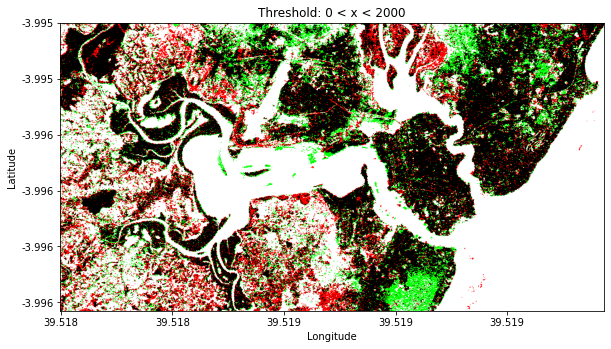

In [15]:
intersection_threshold_plot(baseline_ds, analysis_ds, threshold_range)